# ODYCCEUS Tutorial for the `stream_graph` library

## Venice: September 2019

**git-repository**: https://github.com/ysig/stream_graph  
**documentation**: https://ysig.github.io/stream_graph/doc/  
**install**: pip install git+https://github.com/ysig/stream_graph  
**tutorial-dependencies**: pip install bokeh networkx wordcloud  
**feedback**: [raise an issue in github](https://github.com/ysig/stream_graph/issues) **or** email me at `Yiannis.Siglidis@lip6.fr`

# What is a stream-graph?

A stream-graph is a time-inclusive **generalization** of a static graph.

As we know a static graph, is an object $G = (V, E)$, where:

- $V$, is a set of nodes or the **node-set**
- $E \subseteq V \times V$, is a set of links or the **link-set**

<img src="./karate.png" width="1000">


A stream-graph, is an object $SG = (V, T, W, L)$, where:

- $V$, is a set of nodes or the **node-set**
- $T$, is a collection of time-objects or the **time-set**
- $W \subseteq V \times T$, is a collection of temporal-nodes or the **temporal-node-set**
- $L \subseteq (W \times W) \; / \; T \subseteq V \times V \times T$, is a collection of temporal-links or the **temporal-link-set**


<img src="./sg_example.png" width="1000">

Notice that in a stream-graph we can have both **instantaneous** and interactions with **duration**.

Also for discrete-time, all interactions with **duration**, can be represented as instantaneous interactions.  

We will refer to the **aggregated graph** of a stream-graph as the one defined by it's nodeset V, and all the link that appear inside the temporal-link-set.

# 1 Loading the dataset

## 1.1 Importing libraries

For visualization in this tutorial, we mainly use the bokeh library.

In [1]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show

output_notebook()

Loading BokehJS ...

and matplotlib

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

we will also use an object called `wordCloud`, for displaying circular word-clouds, which you can be installed by `pip install wordcloud`

In [3]:
from wordcloud import WordCloud

for it we initialize a circular mask

In [4]:
import numpy as np

# Make mask
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

we will also use networkx, which you can install by `pip install networkx`

In [5]:
import networkx as nx
nx.__version__

'2.3'

## 1.2 Loading the dataset

In this tutorial we will use the `migrants` dataset, dedicated for this summer school, focusing on the unweighted hashtag network.

This dataset consists of two parts:

1. every single hashtag that appears at a certain date.
2. all the pairs of hashtags, that appeared together at a certain date.

To load and preprocess the data, we will use `pandas` library in order, to transform them to a form that suits our `stream_graph` package.

In [6]:
import pandas as pd

We first load the **csv** file, corresponding to the *temporal-node-set*, as a two column `(u, date)` dataframe of hashtags at each day.  
In order to avoid the interpretation of some hashtags as `nan` values, we would set `keep_default_na` parameter, to `False` in order to interpret everything as a `string`.

In [7]:
tns_df = pd.read_csv('migrant-day-hashtag-simple.zip', names=['date', 'u'], sep=' ', keep_default_na=False)
tns_df.head()

,date,u
0,2015-01-01,シンクビー
1,2015-01-01,エイネーション
2,2015-01-01,01_january
3,2015-01-01,1amthoughts
4,2015-01-01,1u


The second **csv** file we load, corresponds to the *temporal-link-set*, as a dataframe of columns `(u, v, date)`, of hashtag couples and the dates at which they appear. Also for the purpose of this tutorial we will refer to a temporal-link-set by the letter $L$. A classic `link-set` will be notated as $E$.

In [8]:
tls_df = pd.read_csv('migrant-day-hashtag-hashtag-simple.zip', names=['date', 'u', 'v'], sep=' ', keep_default_na=False)
tls_df.head()

,date,u,v
0,2015-01-01,1u,immigration
1,2015-01-01,1vandaag,kukluxklan
2,2015-01-01,1vandaag,rednecks
3,2015-01-01,20h,blueskym
4,2015-01-01,20h,france2


We will first remove the rows, that contain the hashtags that where used as keywords in order to extract this dataset, which are: `migrants, migrant, immigrant, immigrants, emigrants, emigrant`.

In [9]:
remove_words = {'migrant', 'migrants', 'immigrant', 'immigrants', 'emigrant', 'emigrants'}
tns_df = tns_df[~tns_df.u.isin(remove_words)]
tls_df = tls_df[~tls_df.u.isin(remove_words) & ~tls_df.v.isin(remove_words)]

In order for our data to be supported by our library we **need** to substitute the date's with integers.  
As the temporal-node-set should contain the temporal-link-set time-wise, we will make a map of all the dates, from all those appearing inside the first.

In [10]:
date_to_t = {date: i for i, date in enumerate(sorted(list(set(tns_df['date']))))}

and calculate it's inverse for later use (that is for displaying our results).

In [11]:
t_to_date = {i: date  for date, i in date_to_t.items()}

and a function that can turn that into a displayable object

In [12]:
def to_date(t):
    return pd.to_datetime(t_to_date[t], format='%Y-%m-%d')

Now let's apply the map:

In [13]:
tns_df['ts'] = tns_df['date'].map(date_to_t)
tls_df['ts'] = tls_df['date'].map(date_to_t)

and drop the redundant columns

In [14]:
tns_df.drop(columns=['date'], inplace=True)
tls_df.drop(columns=['date'], inplace=True)

So, after the transform we have:

In [15]:
tns_df.head()

,u,ts
0,シンクビー,0
1,エイネーション,0
2,01_january,0
3,1amthoughts,0
4,1u,0


In [16]:
tls_df.head()

,u,v,ts
0,1u,immigration,0
1,1vandaag,kukluxklan,0
2,1vandaag,rednecks,0
3,20h,blueskym,0
4,20h,france2,0


## 1.3 Represent as a Stream Graph

So now we have the right format to initialize our `temporal-node-set` and `temporal-link-set`.  
As you can notice we have discrete-time, non-weighted, instantaneous data-frame.  
We will first import all the classes we our going to use.

In [17]:
from stream_graph import ITemporalNodeSetDF, ITemporalLinkSetDF, StreamGraph

We will pass the value `True` to parameter `discrete` to indicate so.

In [18]:
tns = ITemporalNodeSetDF(tns_df, discrete=True)
tls = ITemporalLinkSetDF(tls_df, discrete=True)

A stream-graph, is a collection of a `node-set`, a `time-set`, a `temporal-node-set` and a `temporal-link-set`.  
So, to initialize a StreamGraph we also need a `node-set` and a `time-set`.  
We extract both from the `temporal-node-set`.  

In [19]:
ns, ts = tns.nodeset, tns.timeset

and initialize our **StreamGraph** as a collection of $(V,\;T,\;W,\;L)$.

In [20]:
sg = StreamGraph(ns, ts, tns, tls)

Now let's plot a small and dense subset of the graph. Displaying days from 0 to 20, we choose keep only the nodes that are part of the first 5 links, which have a duration bigger than 6 and smaller than 15.

In [21]:
from stream_graph import Visualizer

nsu, nsv = zip(*[u for u,d in ITemporalLinkSetDF(tls_df[tls_df.ts <= 20], discrete=True).duration_of() if d>5 and d<15][:5])
sgv = sg.substream(nsu, nsv, [(0, 20)])
Visualizer(y_axis_label='#hashtags').fit(sgv).show()

## 2. Measures

In this section, we will examine a bunch of elementary measures, that are related with the objects that constitute the stream-graph.  
This objects can be referenced as `sg.nodeset_`, `sg.timeset_`, `sg.temporal_nodeset_`, `sg.temporal_linkset_`.  
The underscore here is used to indicate that this class attributes are protected. By ommiting it we will get copies.

### 2.1 Global Measures

- First we count the number of different hashtags: $|V|$

In [22]:
nnodes = sg.nodeset_.size
nnodes

291892

- the number of days that our data spans through: $|T|$

In [23]:
ntimes = sg.timeset_.size
ntimes

546

- the sum of all hashtags at each day: $|W|$

In [24]:
sg.temporal_nodeset_.size

1770866

- calculate the number of nodes, of the Stream-Graph: $$n_{SG} = \sum_{u\in V}n_{u} = \sum_{u\in V}\frac{|T_{u}|}{|T|} = \frac{|W|}{|T|} $$

In [25]:
sg.n

3243.3443223443223

- and calculate the coverage of the stream-graph: $$c(SG) = \frac{|W|}{|V \times T|} = \frac{|W|}{|V| |T|} = \frac{\frac{|W|}{|T|}}{|V|} = \frac{n_{SG}}{|V|}$$

In [26]:
sg.coverage

0.011111453285270998

which indicates us, that the temporal-node-set is *dynamically rich*.   
Furthermore, we can visualize through a wordcloud which hashtags, appear for the most days (**contribute** more).

$$n_{u} = \frac{|T_{u}|}{|T|}$$

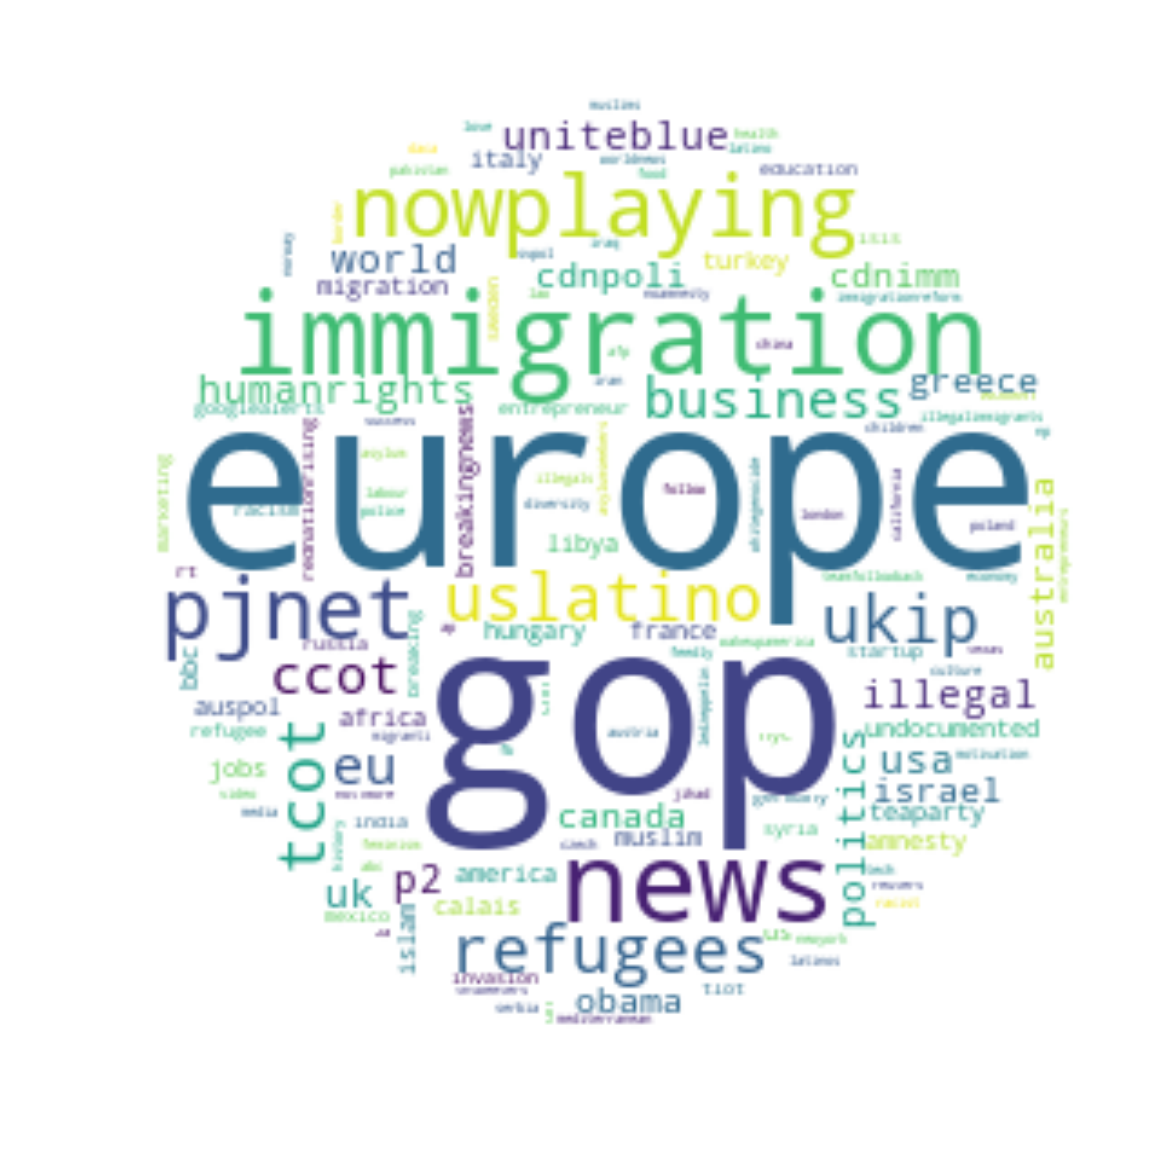

In [27]:
# WordCloud
wc = WordCloud(background_color="white", repeat=True, mask=mask)
wc.fit_words(dict(sg.node_contribution_of()))

# 
plt.rcParams["figure.figsize"] = (10, 10)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

- Also, we will calculate the number of interactions, i.e. the number of hashtag couples: $|L|$

In [28]:
sg.temporal_linkset_.number_of_interactions

6898973

- We will calculate the number of links, of the Stream-Graph: $$m_{SG} = \sum_{u,v \in V}m_{uv} = \sum_{u,v\in V}\frac{|T_{uv}|}{|T|} = \frac{|L|}{|T|}$$

In [29]:
sg.m

12635.481684981685

In a classical graph $G$, the *density* is defined as $$\delta(G) = \frac{|E|}{|V|(|V|-1)}$$ 

In a stream-graph $SG$, this is generalized by defining the density as: $$\delta(SG) = \frac{\sum_{uv \in V}|T_{uv}|}{\sum_{uv \in V}|T_{u} \cap T_{v}|} = \frac{|L|}{\sum_{uv \in V}|T_{u} \cap T_{v}|}$$

In [30]:
sg.density

0.002106755140012308

from which we an observe, that our stream-graph is really sparse.

- Additionaly, we calculate the number of **distinct** hashtag couples $|E|$

In [31]:
sg.temporal_linkset_.m

2495480

### 2.2. Time dimension

In this section we provide some plots, by exploring the data along the time dimension.

- first we plot the number of nodes through time, i.e. the number of different hashtags that appear on each day $|V(t)|$

In [32]:
tv = sg.temporal_nodeset_.n_at()

In [33]:
t, value = zip(*((to_date(t), v) for t, v in tv))
p = figure(x_axis_type="datetime")
p.vbar(x=t, top=value, width=1, line_color="blue")
show(p)

- additionally, we plot a curve of the number of interactions through time, that is the number of different hashtag couples that appear on each day $$|E(t)|$$

In [34]:
tv = sg.temporal_linkset_.m_at()

In [35]:
t, value = zip(*((to_date(t), v) for t, v in tv))
p = figure(x_axis_type="datetime")
p.vbar(x=t, top=value, width=1, line_color="green")
show(p)

- now, if we calculate the density at a given point in time: $$\delta(t) = \frac{|E(t)|}{|V(t)|(|V(t)|-1)}$$

In [36]:
tv = sg.density_at()

In [37]:
t, value = zip(*((to_date(t), v) for t, v in tv))
p = figure(x_axis_type="datetime")
p.vbar(x=t, top=value, width=1, line_color="#a23420")
show(p)

We can see a very different plot than the previous one. Notice that spikes can correspond to days where the hashtags coappear most (we have a more strong topic), but can generally be caused by really small values of $|V(t)|$.

- Now for one particular hashtag ('germany'), we display the number of hashtags related to this given hashtag, on each day. 

In [38]:
tv = sg.temporal_linkset_.degree_at(u='germany')

In [39]:
t, value = zip(*((to_date(t), v) for t, v in tv))
p = figure(x_axis_type="datetime")
p.vbar(x=t, top=value, width=1, line_color="black")
show(p)

- and we compare it with the `neighbor_coverage` of the hashtag, for each day: 
$$\frac{|N_{t}(u)|}{|V(t)|}$$

In [40]:
tv = sg.neighbor_coverage_at(u='germany')

In [41]:
t, value = zip(*((to_date(t), v) for t, v in tv))
p = figure(x_axis_type="datetime")
p.vbar(x=t, top=value, width=1, line_color="black")
show(p)

By doing so, we can observe that around '09/2015' `#germany` is not that significant as it is at the spike after '01/2016', indicating that at the first case we have a general rise of tweets (as we can see on the above plots) and not one dedicated to germany.

### 2.3 Structural dimension

We can also aggregate over time and uncover the structural dimension of our data.

- firstly, we calculate the *global degree* of hashtags, i.e. the sum of the number of neighbors of a hashtag for each day: $$D_{u} = \sum_{t}|N_{u}(t)|$$

and get the list of the hasthags with the highest *global degree*, i.e. hastags which co-appear with most hashtags, cumulatively, for all the days.

In [42]:
u, d = zip(*sg.temporal_linkset_.degree_of())
top_20 = pd.DataFrame({'#': u, 'degree': d}).sort_values(by=['degree'], ascending=False).head(20)
del u, d

In [43]:
p = figure(y_range=top_20['#'])
p.hbar(y=top_20['#'], right=top_20['degree'], height=0.5)
show(p)

- for these hashtags we will investigate the amount of days they co-appear and present it in a heatmap.
  For that we will calculate the duration (number of days) of a pair of hashtags $|T_{uv}|$


In [44]:
ld = sg.temporal_linkset_.duration_of()

In [45]:
valid_hashtag = set(top_20['#'])
hhd = [(a, b, d) for ((a, b), d) in ld if a in valid_hashtag and b in valid_hashtag]
hm_x, hm_y, hm_z = zip(*hhd)

extract the subset that we want

In [46]:
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper, ColumnDataSource, PrintfTickFormatter
from bokeh.transform import transform
from bokeh.palettes import plasma

# Structure the data
source = {'#1': hm_x, '#2':  hm_y, 'value': hm_z}

# You can use your own palette here
colors = plasma(20)[::-1]

# Had a specific mapper to map color with value
mapper = LinearColorMapper(palette=colors, low=min(hm_z), high=max(hm_z))

# Make the figure
p = figure(x_range=list(top_20['#']), y_range=list(top_20['#']))
p.rect(source=source, x='#1', y='#2', width=1, height=1, fill_color=transform('value', mapper))

# Add legend
color_bar = ColorBar(color_mapper=mapper, location=(0, 0),
                     ticker=BasicTicker(desired_num_ticks=len(colors)))

p.add_layout(color_bar, 'right')
p.xaxis.major_label_orientation = 3.14/4
show(p)

- Also we plot the distribution of those durations for each hashtag.

In [47]:
DF = pd.DataFrame([(a, b, d) for ((a, b), d) in ld], columns=['#1', '#2', 'duration'])
del ld

In [48]:
from collections import Counter
ct = Counter(DF['duration'])
x, d = zip(*sorted(list(ct.items())))
p = figure(x_axis_type="log", y_axis_type="log")
p.vbar(x=x, top=d, width=1, bottom=1)
show(p)

We will now extract the most couple of hashtags, by keeping only those which have a duration higher that of more than 430 days. We will respresent them as a Graph, coverting them from our-library's `graph` to `networkx`.  We selected 430, by trial an error as we wanted the resulted graph be visible, when plotted.

In [49]:
from stream_graph import LinkSetDF
gr = LinkSetDF(DF[DF['duration'] > 430], weighted=True).as_graph
del DF
gr.n, gr.m

(63, 162)

Now let's convert our graph object to a networkx graph, to plot it.

In [50]:
G = gr.to_networkx()

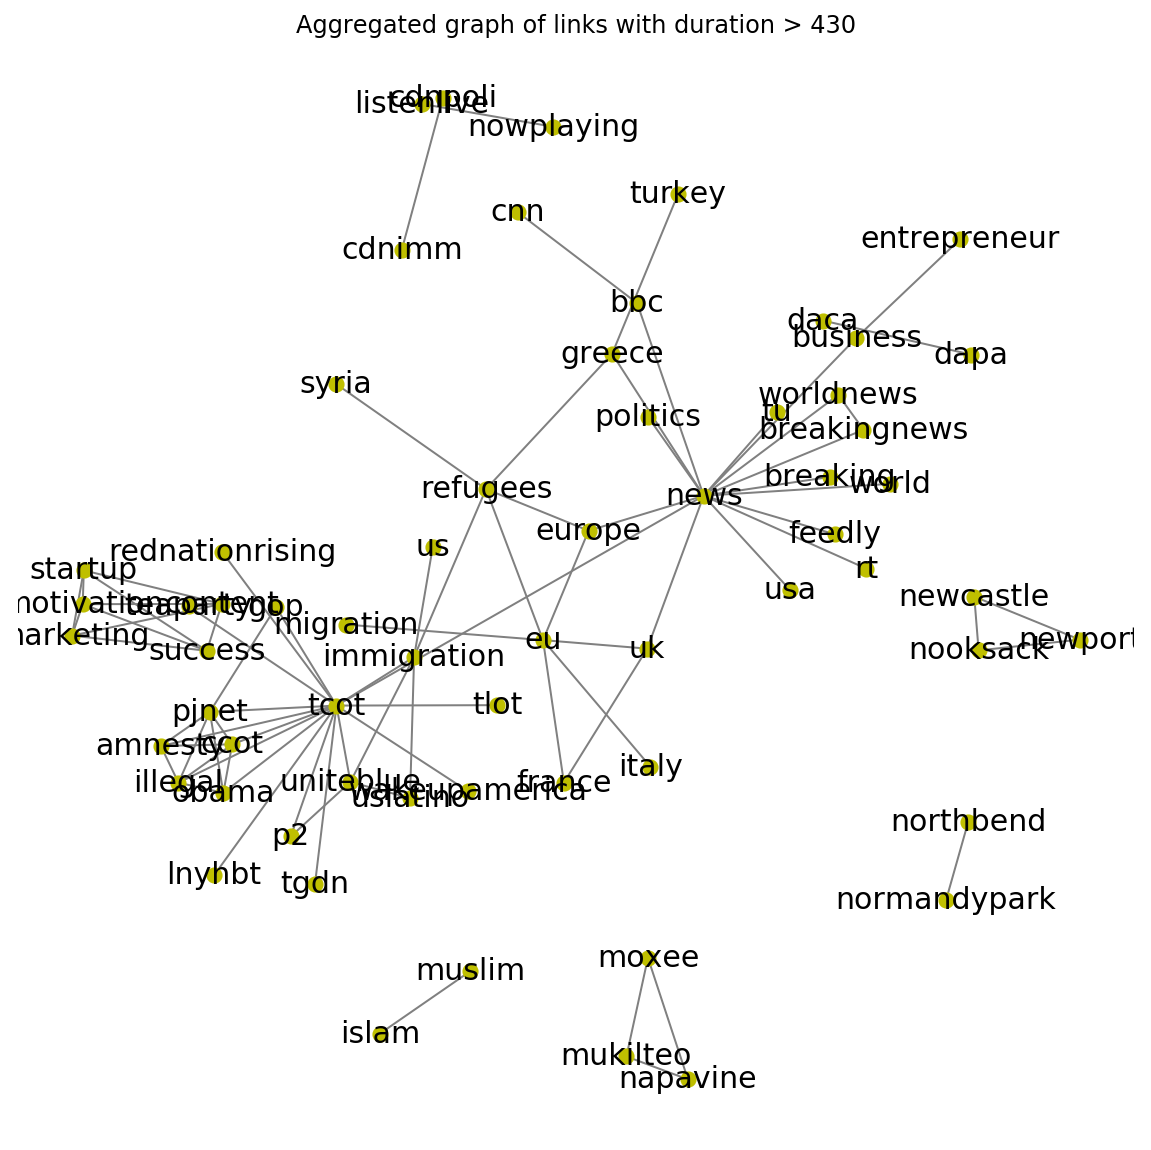

In [51]:
# Layout
pos=nx.spring_layout(G, k=3)

nx.draw_networkx_nodes(G, pos, node_color='y', node_size=50)
nx.draw_networkx_edges(G, pos, width=1, edge_color='grey')
nx.draw_networkx_labels(G, pos, font_size=15)

# Plot the graph
plt.rcParams["figure.figsize"] = (10, 15)
plt.axis('off')
plt.title('Aggregated graph of links with duration > 430')
plt.show()

## 3.Complex measures

A lot of measures of the classical graph theoy can be generalized to Stream-Graphs.
From maximal-cliques and k-cores, to paths and closeness measures, people in our team are developing algorithms and code, in order to have these tools at hand in the future.


For the purpose of this tutorial, we focus on the time-period after the first day and before the '01/04/2015'.  
We also keep the hashtags that appear for at-least 20 days (i.e. 20 times) in the temporal-node-set.
In this dsubset of the data, we calculate measures of centrality and maximal-cliques.

In [52]:
t_to_date[0]

'2015-01-01'

In [53]:
sg_sub = sg.substream(ts=[(0, date_to_t['2015-04-01'])])

In [54]:
nd = {n: d for n, d in sg_sub.temporal_nodeset_.duration_of() if d >= 20}
u = set(nd.keys())
len(u)

1606

We display the world cloud, which can be produced by the frequency of all these nodes.

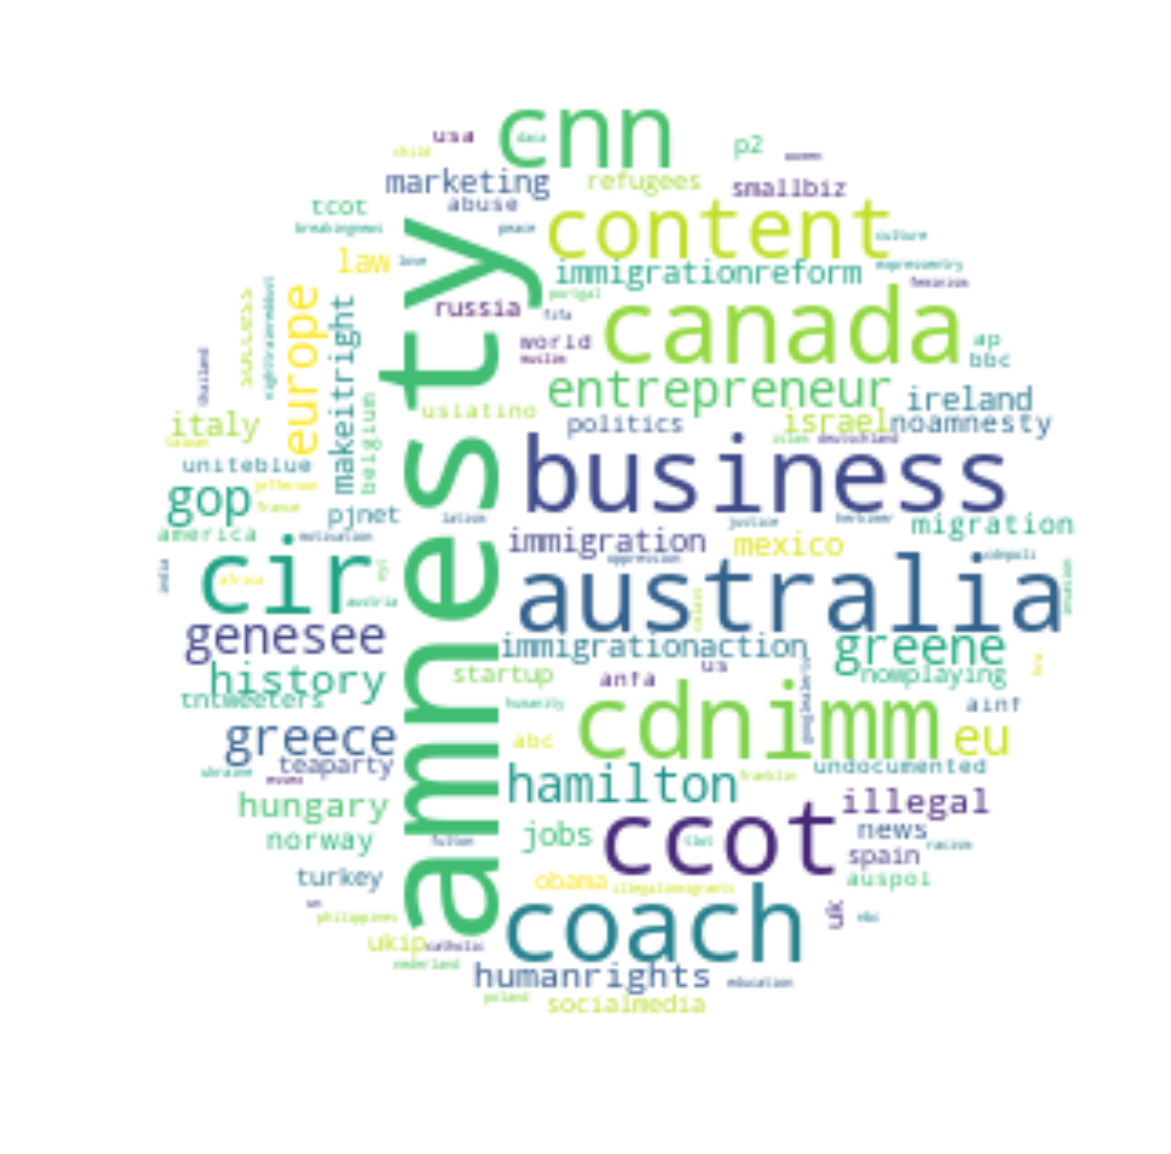

In [55]:
# fit node-duration
wc = WordCloud(background_color="white", repeat=True, mask=mask)
wc.fit_words(nd)

# plot
plt.rcParams["figure.figsize"] = (10, 10)
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()

Now if we keep only the nodes that appear for at-least 20 days

In [56]:
sg_sub = sg_sub.substream(nsu=u, nsv=u)
sg_sub.temporal_linkset_.df_.shape

(324550, 3)

and extract the aggregated graph.

In [57]:
agg = sg_sub.aggregated_graph.to_networkx()

### 3.1. Closeness-Centrality

In a classical graph, closeness centrality (or closeness) of a node is a measure of centrality in a network, calculated as the reciprocal of the sum of the length of the shortest paths, between the node and all other nodes in the graph. Thus, the more central a node is, the closer it is to all other nodes.

Closeness was defined by Bavelas (1950) as the reciprocal of the farness that is:
$$C(v) = \frac{1}{\sum_{u \neq v}d(u, v)}$$

<img src="./cg.png" width="700">


In this graph we can observe that the node with the highest closeness is the black.
We calculate, for each hashtag in the aggregated static graph, it's closeness-centrality

In [58]:
%%time
cc = nx.closeness_centrality(agg)

CPU times: user 37.5 s, sys: 2.38 ms, total: 37.5 s
Wall time: 37.5 s


In [59]:
DF_c = pd.DataFrame([(u, c) for u, c in cc.items()], columns=['#', 'closeness'])
top_20 = DF_c.sort_values(by=['closeness'], ascending=False).head(20)

and plot the top 20 

In [60]:
p = figure(y_range=top_20['#'])
p.hbar(y=top_20['#'], right=top_20['closeness'], height=0.5)
show(p)


Temporal-closeness-centrality defined by Matthieu Latapy et al. (2017), is similarly equal to:
$$C_{t}(v) = \frac{1}{\sum_{u \neq v}d_{t}(u, v)}$$

Where $d_{t}(u, v)$ represents the distance of u to v at time t.
So this measure of temporal-closeness-centrality can 1) vary through time and 2) be different from the value of the classical-closeness-centrality on the aggregated graph.

The importance of having temporal closeness, can be illustrated on the following plot:

<img src="./closeness_example.png" width="800">

Finally, notice that this measure of temporal-closeness is different from calculating the classic closeness on the snapshot graph (on the graph active at each time-stamp), as paths of the past have an importance for calculating a value at a current time-stamp.

In [61]:
%%time
tc = sg_sub.temporal_linkset_.closeness(t='max')

CPU times: user 1min 46s, sys: 44.8 ms, total: 1min 46s
Wall time: 1min 46s


and present the top-20 hashtags according to closeness

In [62]:
DF_tc = pd.DataFrame([(u, mxc, ts) for u, (mxc, ts) in tc], columns=['#', 'max-closeness', 'ts']).sort_values(by=['max-closeness', 'ts'], ascending=False)
top_20 = DF_tc.head(20)

In [63]:
y, r = zip(*[(str(u) + "@ " + t_to_date[t], c) for u, c, t in top_20.itertuples(name=None, index=False)])
p = figure(y_range=y)
p.hbar(y=y, right=r, height=0.5)
show(p)

- also we plot and compare the temporal-closeness-centrality for two given nodes, through time

In [64]:
tv_md = sg_sub.temporal_linkset_.closeness(u='mediterranean')
tv_usa = sg_sub.temporal_linkset_.closeness(u='usa')

In [65]:
t_md, v_md = zip(*((to_date(t), v) for t, v in tv_md))
t_usa, v_usa = zip(*((to_date(t), v) for t, v in tv_usa))

p = figure(x_axis_type="datetime")
p.step(x=t_md, y=v_md, line_color="blue", mode="after", legend='mediterranean')
p.step(x=t_usa, y=v_usa, line_color="red", mode="after", legend='usa')
show(p)

As we see by comparing these two plots, the hashtag 'mediterran', starts being raised to a **central** topic inside the February of 2015 and 'usa' becomes a bit more central for this region, indicating a possible correlation between these two topics.

## 3.2 Maximal-Cliques



A clique in a classic graph is defined as a set of nodes, where there exists a link between all pairs of nodes (subgraphs of density 1).

<img src="./graph-clique.png" width="500">


In [66]:
cliques = nx.find_cliques(agg)

and print the top-10 maximal-cliques, sorted by size

In [67]:
sorted_cliques = sorted(list(cliques), key=lambda x:len(x), reverse=True)
for c in sorted_cliques[:10]:
    print(', '.join(c), end='\n\n')

immigration, usa, tcot, obama, gop, sotu, uniteblue, immigrationreform, latinos, cir, undocumented, immigrationaction, republicans, latino, tntweeters, daca, dreamers, uslatino, potus

immigration, usa, tcot, obama, gop, sotu, uniteblue, immigrationreform, latinos, cir, undocumented, immigrationaction, republicans, latino, tntweeters, daca, dreamers, uslatino, latism

immigration, usa, tcot, obama, gop, p2, latinos, immigrationreform, uniteblue, texas, undocumented, immigrationaction, latino, dreamers, latism, tntweeters, republicans, daca, uslatino

immigration, usa, tcot, obama, gop, p2, latinos, immigrationreform, uniteblue, cir, tntweeters, uslatino, republicans, dreamers, daca, immigrationaction, latino, undocumented, latism

immigration, dapa, daca, tcot, obama, undocumented, immigrationaction, gop, immigrationreform, dreamers, dhs, p2, tntweeters, latism, republicans, uslatino, latinos, latino, texas

immigration, dapa, daca, tcot, obama, undocumented, immigrationaction, gop, im

In a similar fashion with static graphs, a clique in a temporal-link-set is a collection of nodes that are all connected with each other during a given period of time. 

<img src="./link-stream-clique.png" width="800">

In [68]:
%%time
mxc = sg_sub.temporal_linkset_.get_maximal_cliques()

CPU times: user 6min 50s, sys: 5.69 s, total: 6min 55s
Wall time: 6min 55s


and again print the top-6, sorted by size

In [69]:
sorted_cliques = sorted(list(mxc), key=lambda x:len(x[0]), reverse=True)
for c, t in sorted_cliques[:6]:
    print(t_to_date[t[0]],'->',t_to_date[t[1]],':',', '.join(c), end='\n\n')

2015-03-13 -> 2015-03-19 : northface, antihero, cbs, nyt, abc, dear, cnn, ap, nbc, supreme, wsj, bbc, reuters

2015-01-01 -> 2015-01-06 : northface, antihero, reuters, cbs, abc, dear, cnn, ap, nbc, wsj, supreme, bbc, nyt

2015-03-29 -> 2015-03-30 : northface, antihero, reuters, cbs, abc, dear, cnn, ap, nbc, wsj, supreme, bbc, nyt

2015-01-09 -> 2015-01-17 : northface, antihero, reuters, cbs, abc, dear, cnn, ap, nbc, wsj, supreme, bbc, nyt

2015-01-19 -> 2015-02-04 : northface, antihero, reuters, cbs, nyt, abc, dear, cnn, nbc, wsj, supreme, bbc, ap

2015-03-21 -> 2015-03-27 : northface, antihero, reuters, cbs, nyt, abc, dear, cnn, nbc, wsj, supreme, bbc, ap



but we can also print the top-6, sorted by duration.

In [70]:
sorted_cliques = sorted(list(mxc), key=lambda x:x[1][1] - x[1][0], reverse=True)
for c, t in sorted_cliques[:6]:
    print(t_to_date[t[0]],'->',t_to_date[t[1]],':', ', '.join(c), end='\n\n')

2015-01-01 -> 2015-04-01 : smallbiz, entrepreneur

2015-01-01 -> 2015-04-01 : business, entrepreneur

2015-01-01 -> 2015-04-01 : success, startup

2015-01-01 -> 2015-04-01 : business, entrepreneur, marketing, success, smallbiz, coach

2015-01-01 -> 2015-04-01 : tcot, pjnet

2015-01-01 -> 2015-04-01 : hamilton, genesee



Finally, we make a 2D plot of duration vs clique-size.

In [71]:
list_x, list_y, desc = zip(*((len(clique), tf-ts, ','.join(clique)) for clique, (ts, tf) in mxc))

In [72]:
# size versus duration bidimensional plot
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.transform import transform

source = ColumnDataSource(data=dict(x=list_x, y=list_y, desc=desc))
hover = HoverTool(tooltips=[("clique-size", "@x"), ("duration", "@y"), ('clique', '@desc')])
mapper = LinearColorMapper(palette=plasma(256), low=min(list_y), high=max(list_y))

p = figure(tools=[hover], x_axis_label='Clique size', y_axis_label='Duration')
p.circle('x', 'y', size=10, source=source, fill_color=transform('y', mapper))

show(p)

By doing such a comparison we can thoroughly investigate cliques, depending on what we consider more important, namely the duration of their appearance or their size. With a first observation we can understand, that by looking to points that approach the top right part of the plot, we can see which cliques appear for the most days and together with that, have the maximum size.